# Gerenciador de investimentos

Bibliotecas e opções

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from plotly import tools
import plotly.graph_objs as go
from lib import lib as l

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
lcolors = np.array(['#13E881', '#FF5949', '#FFB84C', '#A7BEFA'])
dcolors = np.array(['#268040', '#800B00', '#A13808', '#464CC2'])

## Leitura dos dados

In [3]:
df = pd.read_csv('br_invest.csv')
df['Data'] = df['Data'].apply(lambda x : dt.datetime.strptime(str(x),'%d/%m/%y').date())
df.tail()


,ID,Valor,Data,Status,Tipo
25,5.100,1061.910,2019-12-24,Mes,Nu
26,6.000,846.650,2019-12-24,Mes,Nu
27,100.000,1415.500,2019-12-24,Mes,IVVB
28,101.000,957.000,2019-12-24,Mes,BRAX
29,102.000,1415.500,2019-12-24,Mes,IVVB


## Fluxos de investimentos

### Histórico de fluxos

In [4]:
di = df.groupby('ID').apply(l.calc_flows)
di = di.reset_index(level=[0, 1])
di.pop('level_1')
di = di.sort_values(by=['Rendimento anual'], ascending=False).reset_index(drop=True)
di

,ID,Valor inicial,Ganho,Meses,Rendimento,Rendimento mensal,Rendimento anual,Ativo,Tipo
0,101.000,875.270,81.730,1.311,9.338,7.044,126.331,True,BRAX
1,102.000,1390.930,24.570,0.393,1.766,4.551,70.585,True,IVVB
2,100.000,1308.400,107.100,1.803,8.186,4.460,68.803,True,IVVB
3,5.100,1059.610,2.300,0.492,0.217,0.442,5.433,True,Nu
4,1.000,12491.070,48.940,1.115,0.392,0.351,4.299,False,Nu
5,3.100,1989.970,9.020,1.311,0.453,0.345,4.225,True,Nu
6,2.000,715.200,2.270,0.951,0.317,0.334,4.080,False,Nu
7,4.100,10.100,0.020,0.623,0.198,0.318,3.884,False,Nu
8,1.100,10940.620,57.890,1.770,0.529,0.299,3.642,True,Nu
9,3.000,2002.290,1.620,0.459,0.081,0.176,2.137,False,Nu


### Fluxos ativos

In [5]:
di[di['Ativo']]

,ID,Valor inicial,Ganho,Meses,Rendimento,Rendimento mensal,Rendimento anual,Ativo,Tipo
0,101.000,875.270,81.730,1.311,9.338,7.044,126.331,True,BRAX
1,102.000,1390.930,24.570,0.393,1.766,4.551,70.585,True,IVVB
2,100.000,1308.400,107.100,1.803,8.186,4.460,68.803,True,IVVB
3,5.100,1059.610,2.300,0.492,0.217,0.442,5.433,True,Nu
5,3.100,1989.970,9.020,1.311,0.453,0.345,4.225,True,Nu
8,1.100,10940.620,57.890,1.770,0.529,0.299,3.642,True,Nu
11,6.000,846.360,0.290,0.361,0.034,0.095,1.146,True,Nu


## Performance

In [6]:
dnu = di[di['Meses'] > 0]
dnu = dnu[dnu['Tipo'] == 'Nu']

detf = di[di['Meses'] > 0]
detf = detf[detf['Tipo'] != 'Nu']

### Renda fixa

In [7]:
gain = dnu['Ganho'].sum()
total_yield = gain / dnu['Valor inicial'].sum()
monthly_yield = (1+total_yield)**(1/dnu['Meses'].max())-1
annual_yield = (1+monthly_yield)**12-1
dav = pd.DataFrame([[gain, str(round(total_yield*100, 2)) + ' %', str(round(annual_yield*100, 2)) + ' %']], 
                   columns=['Ganho atual', 'Rendimento atual', 'Rendimento anual'])
dav = l.change_df_prop(dav)
dav

Ganho atual,Rendimento atual,Rendimento anual
122.72,0.4 %,2.72 %


### Renda Variável

In [8]:
gain = detf['Ganho'].sum()
total_yield = detf['Ganho'].sum() / detf['Valor inicial'].sum()
monthly_yield = (1+total_yield)**(1/detf['Meses'].max())-1
annual_yield = (1+monthly_yield)**12-1
dav = pd.DataFrame([[gain, str(round(total_yield*100, 2)) + ' %', str(round(annual_yield*100, 2)) + ' %']], 
                   columns=['Ganho atual', 'Rendimento atual', 'Rendimento anual'])
dav = l.change_df_prop(dav)
dav

Ganho atual,Rendimento atual,Rendimento anual
213.4,5.97 %,47.09 %


### Mensal

In [9]:
dret = l.group_sum(l.calc_flow_gains(df), group=['Tipo'], date='month').fillna(0)
dret['Total'] = dret.sum(axis=1)
dret = l.window_mean(dret, 'BRAX')
dret = l.window_mean(dret, 'IVVB')
dret = l.window_mean(dret, 'Nu')
dret = l.window_mean(dret, 'Total')

In [10]:
fig = l.plot_bar(dret, y='Nu', color=lcolors[3], name='Rendimento (Nu)')
fig = l.plot_line(dret, fig=fig, y='NuAvg', color=dcolors[3], name='Rendimento médio (Nu)')
fig = l.plot_bar(dret, y='BRAX', fig=fig, color=lcolors[2], name='Rendimento (BRAX)')
fig = l.plot_line(dret, fig=fig, y='BRAXAvg', color=dcolors[2], name='Rendimento médio (BRAX)')
fig = l.plot_bar(dret, y='IVVB', fig=fig, color=lcolors[0], name='Rendimento (IVVB)')
l.plot_line(dret, fig=fig, y='IVVBAvg', color=dcolors[0], name='Rendimento médio (IVVB)')

FigureWidget({
    'data': [{'marker': {'color': '#A7BEFA'},
              'name': 'Rendimento (Nu)',
        …

In [11]:
fig = l.plot_bar(dret, y='Total', color=lcolors[0], name='Rendimento')
l.plot_line(dret, fig=fig, y='TotalAvg', color=dcolors[0], name='Rendimento médio')

FigureWidget({
    'data': [{'marker': {'color': '#13E881'},
              'name': 'Rendimento',
             …

## Correlação de atributos

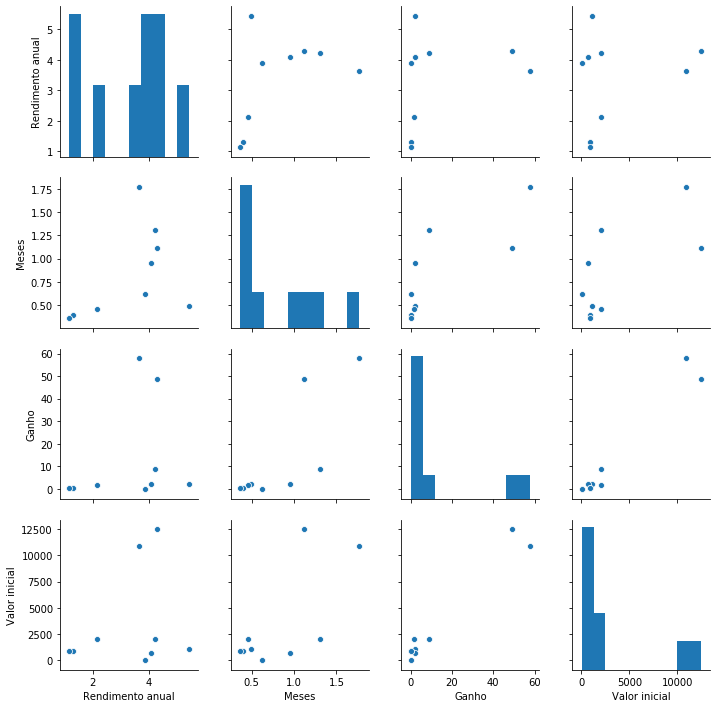

In [12]:
sns.pairplot(dnu, vars=['Rendimento anual', 'Meses', 'Ganho', 'Valor inicial'])

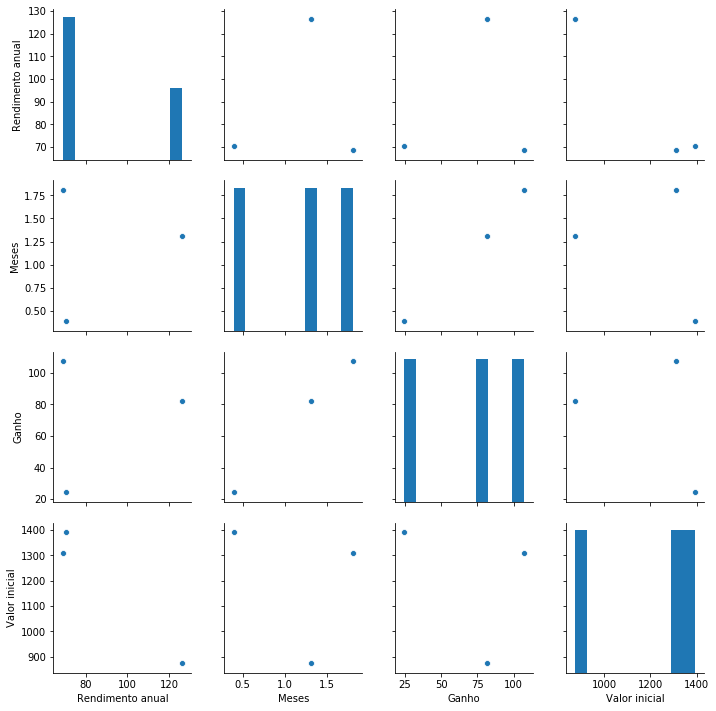

In [13]:
sns.pairplot(detf, vars=['Rendimento anual', 'Meses', 'Ganho', 'Valor inicial'])